### Semantic Segmentation with Stardist

In [1]:
#import cv2
import json
import os
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split
from csbdeep.utils import Path, normalize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
import shutil 
from tqdm import tqdm

from stardist.matching import matching, matching_dataset
from stardist.utils import mask_to_categorical
from stardist.plot import render_label

np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20



2025-03-10 15:01:32.677316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741615292.696151 1501973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741615292.700435 1501973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 15:01:32.716443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
### Variables
ERK_FILE = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp01_Site02.tif'
H2B_FILE = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp01_Site02.tif'
GT_FILE = '/home/nbahou/myimaging/apoDet/data/apo_masks/Exp01_Site02.npz'
CLASS_DICTS = '/home/nbahou/myimaging/apoDet/scripts/extras/class_dicts/Exp01_Site02.json'

TEST_SIZE = 0.2    # -> percentage of data for validation

STRDST_MODELS_DIR = './models'
MODEL_NAME = '2D_sem_apo'
n_classes = 2
SAVE_INFO_PATH = './strdst_model_info'
SAVE_MODEL_INFO = True    #-> saves config
SAVE_LEARNING_METRICS = True    #-> saves info for plotting

# Plotting settings
VISUALIZE_LEARNING = True
CMAP = 'Set2'

# Training parameters
NUM_EPOCHS = 100
STEPS_PER_EPOCH = 50
BATCH_SIZE = 8
USE_GPU = True

# LOAD_MASKS = True

In [13]:
### Code for use with tiff stacks
# Load dataset
def load_data(erk_file):
    # Load multi-page .tif files
    erk_images = tiff.imread(erk_file)

    # TODO read in multiple tiff files
   
    return erk_images

# Load ERK images and the groundtruth masks
erk_images = load_data(ERK_FILE)#[:,2,:,:]
print(erk_images.shape)
masks = np.load(GT_FILE)['gt']
#masks = np.load(GT_FILE, )['gt']

# Load class dicts
with open(CLASS_DICTS, 'r') as json_file:
    cls_dictionaries = json.load(json_file)
cls_dicts = []


for dictionary in cls_dictionaries:
    cls_dict = {int(k): v for k, v in dictionary.items()}
    cls_dicts.append(cls_dict)



# Normalize erk images as suggested in stardist manual
axis_norm = (0,1)   # normalize channels independently

erk_images_normal = np.asarray([normalize(img,1,99.8,axis=axis_norm) for img in erk_images])
print(f"Shape of ERK images: {erk_images_normal.shape}")
print(f"Shape of masks: {masks.shape}")


# Split the data into training and validation sets
X_train, X_val, y_train, y_val, cls_train, cls_val = train_test_split(erk_images_normal, 
                                                                      masks, 
                                                                      cls_dicts, 
                                                                      test_size=TEST_SIZE, 
                                                                      random_state=42)


print(f"Training set: {len(cls_train)} images")
print(f"Validation set: {len(cls_val)} images")

(1441, 1024, 1024)
Shape of ERK images: (1441, 1024, 1024)
Shape of masks: (1441, 1024, 1024)
Training set: 1152 images
Validation set: 289 images


In [14]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [15]:
### Training for pretrained model
## Load pretrained model 
# current_model_path = os.path.join(STRDST_MODELS_DIR, MODEL_NAME)

# make a copy of a pretrained model into folder 'mymodel' if it doesn't exist
#if not os.path.exists(current_model_path):
#    model_pretrained = StarDist2D.from_pretrained('2D_versatile_fluo')    # -> load pretrained model
#    shutil.copytree(model_pretrained.logdir, current_model_path, dirs_exist_ok=False)

## If we have gpu available (from documentation example)
if USE_GPU:
    import gputools
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

n_channel = 1 if erk_images_normal[0].ndim == 2 else erk_images_normal[0].shape[-1]

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = USE_GPU,
    n_channel_in = n_channel,
    train_epochs = NUM_EPOCHS,
    train_steps_per_epoch = STEPS_PER_EPOCH,
    train_batch_size = BATCH_SIZE,
    n_classes = n_classes
)


model = StarDist2D(conf, name=MODEL_NAME, basedir='models')



# run training
history = model.train(X_train, y_train, classes=cls_train, validation_data=(X_val, y_val, cls_val), augmenter=augmenter)

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/100


I0000 00:00:1741617017.285886 1559988 service.cc:148] XLA service 0x7a404c0027a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741617017.285920 1559988 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-10 15:30:17.789301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741617022.716478 1559988 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741617031.194602 1559988 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 570ms/step - dist_dist_iou_metric: 0.0376 - dist_loss: 15.6600 - dist_relevant_mae: 15.6599 - dist_relevant_mse: 342.9818 - loss: 4.0209 - prob_class_loss: 0.2753 - prob_kld: 0.3849 - prob_loss: 0.6135 - val_dist_dist_iou_metric: 0.1957 - val_dist_loss: 10.1628 - val_dist_relevant_mae: 10.1448 - val_dist_relevant_mse: 175.0497 - val_loss: 2.5202 - val_prob_class_loss: 0.0152 - val_prob_kld: 0.2478 - val_prob_loss: 0.4759 - learning_rate: 3.0000e-04
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - dist_dist_iou_metric: 0.3433 - dist_loss: 8.4586 - dist_relevant_mae: 8.4574 - dist_relevant_mse: 123.1492 - loss: 2.1977 - prob_class_loss: 0.0142 - prob_kld: 0.2662 - prob_loss: 0.4918 - val_dist_dist_iou_metric: 0.4078 - val_dist_loss: 7.4515 - val_dist_relevant_mae: 7.4381 - val_dist_relevant_mse: 93.9468 - val_loss: 1.9728 - val_prob_class_loss: 0.0152 - val_prob_kld: 0.2415 - val_prob_loss: 0.4696 - learning_rate: 3.0000e-04
Epoch 3/100
50/50 ━━━━━━━

In [17]:
### Optimize thresholds
# this step probably needs more than 10gb of memory
model.optimize_thresholds(X_val, y_val)

functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, None, None, 1))
NMS threshold = 0.5:  75%|██████████████████████████████████▌           | 15/20 [12:02<04:00, 48.19s/it, 0.550 -> 0.949]


Using optimized values: prob_thresh=0.506719, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5067185206140714, 'nms': 0.3}

In [16]:
### Save information about model
model_info_path = os.path.join(SAVE_INFO_PATH, MODEL_NAME)

# Create directory for saving if necessary
if SAVE_MODEL_INFO or SAVE_LEARNING_METRICS:
    if not os.path.exists(model_info_path):
        os.makedirs(model_info_path, exist_ok=False)
   
# Save model information
if SAVE_MODEL_INFO:
    # Save config
    config_file_path = os.path.join(model_info_path, 'strdst_config.txt')

    with open(config_file_path, 'w') as file:
        file.write(str(model.config))

    print(f"Model configuration saved to {config_file_path}")

if SAVE_LEARNING_METRICS:
    # Save learning metrics
    history_file_path = os.path.join(model_info_path, 'strdst_history.txt')

    # Save history as JSON file
    with open(history_file_path, 'w') as file:
        json.dump(history.history, file)
    
    print(f"Training history saved to {history_file_path}")







Model configuration saved to ./strdst_model_info/2D_sem_apo/strdst_config.txt
Training history saved to ./strdst_model_info/2D_sem_apo/strdst_history.txt


Plot saved to: ./strdst_model_info/2D_sem_apo/learn_metrics.png


<Figure size 640x480 with 0 Axes>

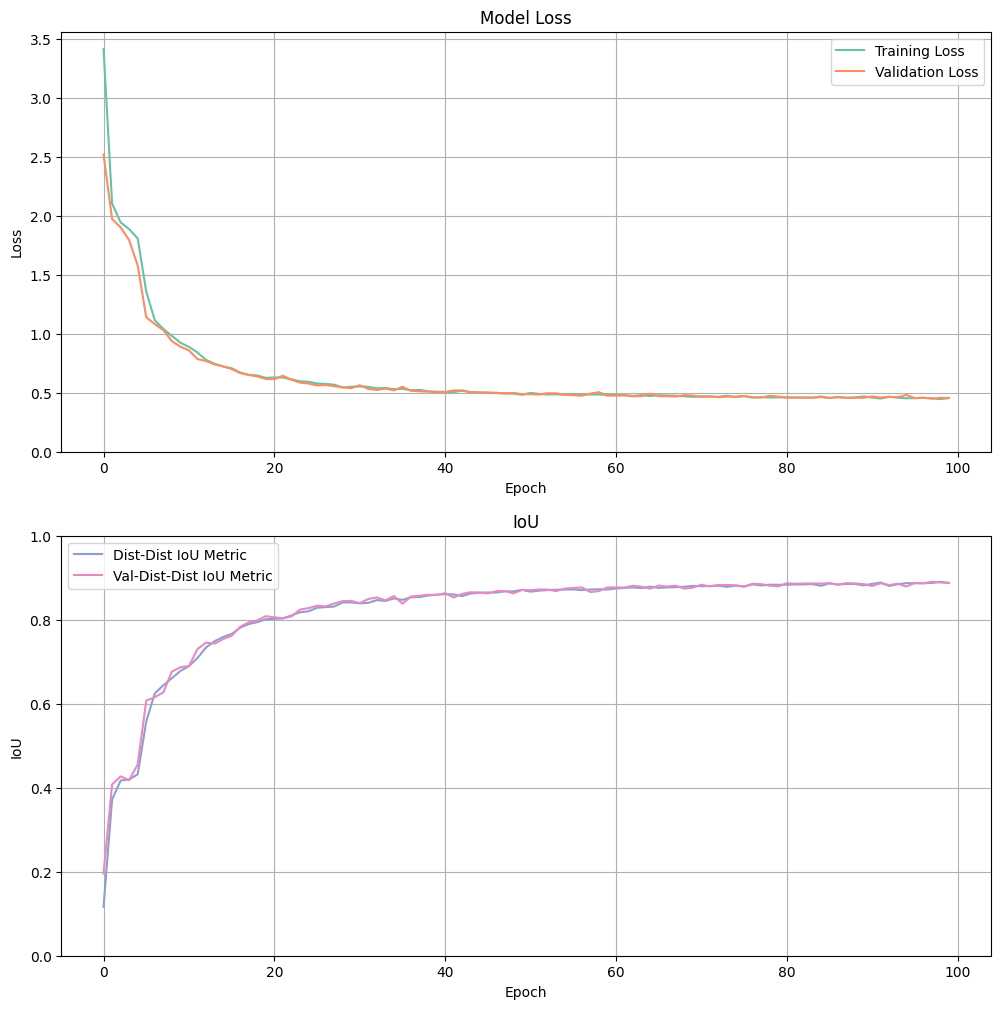

In [18]:
if VISUALIZE_LEARNING:
    # Set the colormap to Pastel2
    plt.set_cmap(CMAP)
    cmap = plt.get_cmap(CMAP)

    
    # Create a figure to hold the subplots
    plt.figure(figsize=(12, 12))  # Adjusted to hold two plots vertically
    
    # Plot training & validation loss values in the first subplot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss', color=cmap(0))
    plt.plot(history.history['val_loss'], label='Validation Loss', color=cmap(1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(bottom=0)
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot IoU metric values in the second subplot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['dist_dist_iou_metric'], label='Dist-Dist IoU Metric', color=cmap(2))
    plt.plot(history.history['val_dist_dist_iou_metric'], label='Val-Dist-Dist IoU Metric', color=cmap(3))
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.ylim(bottom=0, top=1)
    plt.title('IoU')
    plt.legend()
    plt.grid(True)

    if SAVE_LEARNING_METRICS:
        # Define the directory to save the plot
        model_info_path = os.path.join(SAVE_INFO_PATH, MODEL_NAME)
        
        # Create dir if it doesn't exist
        if not os.path.exists(model_info_path):
            os.makedirs(model_info_path)
        
        
        # Save the combined plot
        combined_plot_path = os.path.join(model_info_path, 'learn_metrics.png')
        plt.savefig(combined_plot_path)

        print(f'Plot saved to: {combined_plot_path}')
        
    # Display the combined plot
    plt.show()


In [19]:
y_val_pred, res_val_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_val[:])]))


100%|█████████████████████████████████████████████████████████████████████████████████| 289/289 [02:38<00:00,  1.83it/s]


In [26]:
lbl_cmap_classes = matplotlib.cm.tab10

def plot_img_label(img, lbl, cls_dict, n_classes=10, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    class_img[...,:3][res==0] = 0 
    class_img[...,-1][res==0] = 1
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(class_img)
    ac.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict


(<Axes: title={'center': 'image'}>,
 <Axes: title={'center': 'label Pred'}>,
 <Axes: title={'center': 'classes'}>)

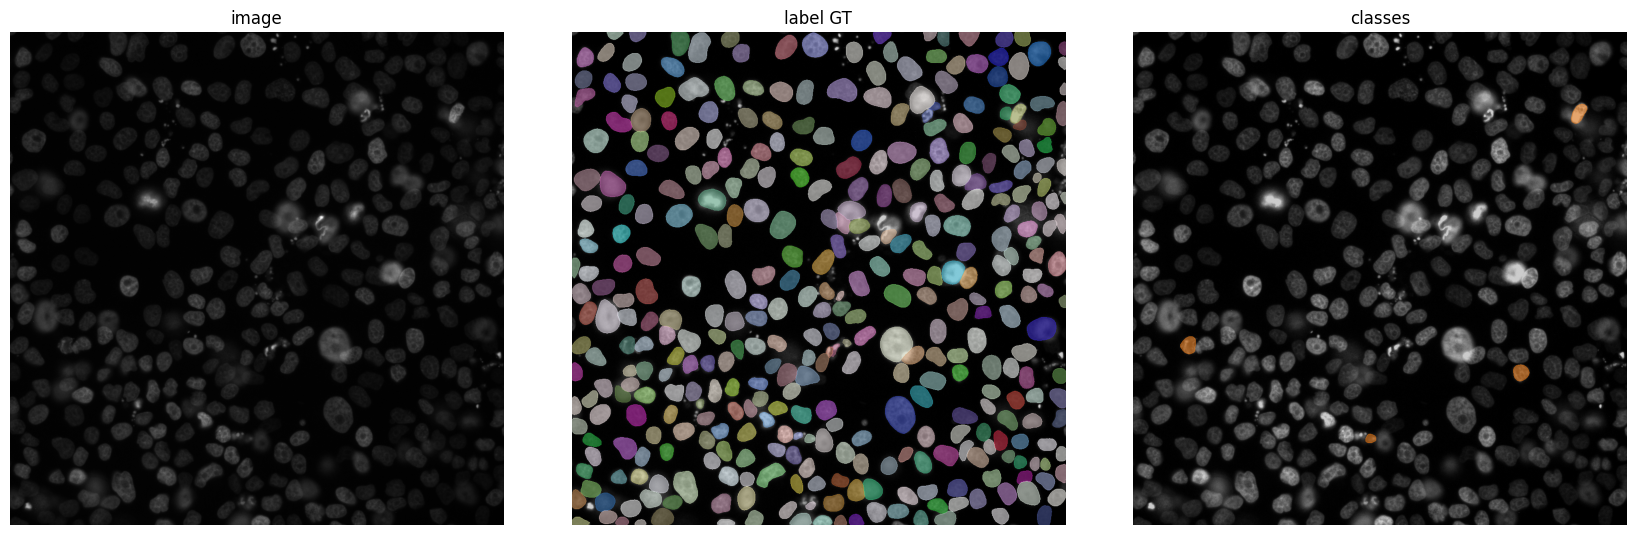

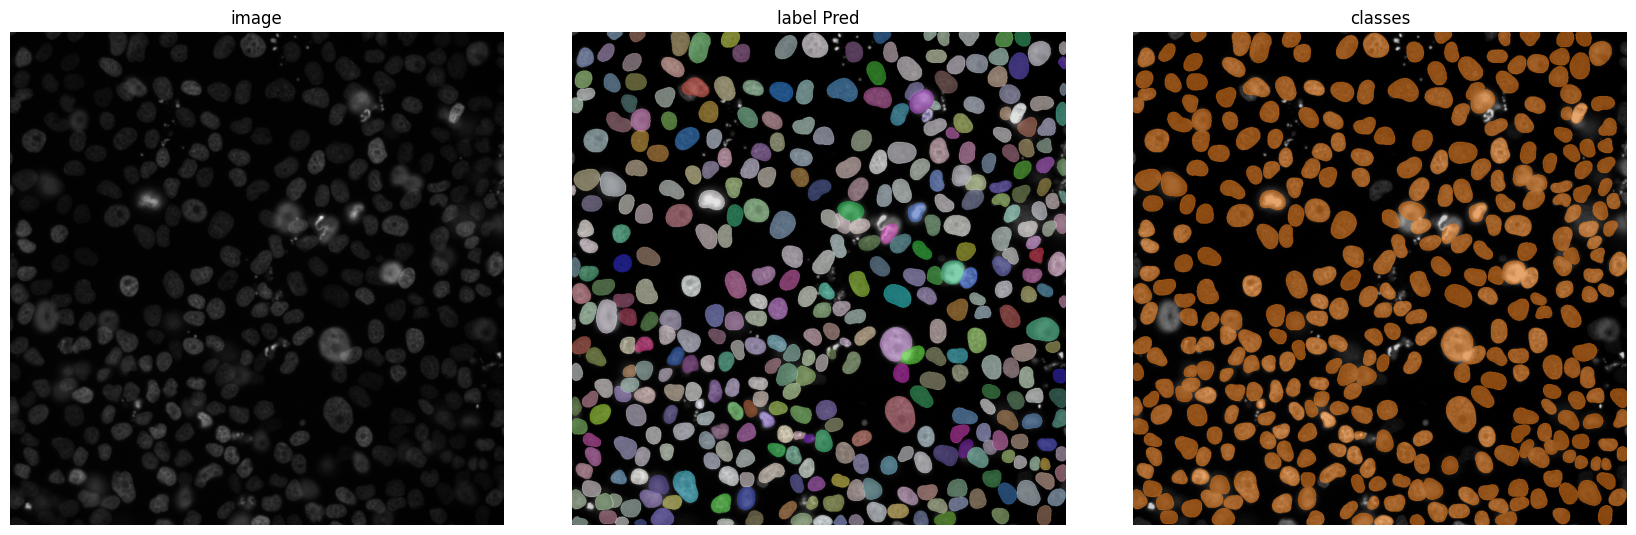

In [29]:
i = 80
plot_img_label(X_val[i],y_val[i], cls_val[i], lbl_title="label GT")
plot_img_label(X_val[i],y_val_pred[i], class_from_res(res_val_pred[i]), lbl_title="label Pred")


In [30]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(y_val, y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:24<00:00,  9.42s/it]


In [31]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=2349, tp=111280, fn=2631, precision=0.9793274604194352, recall=0.9769030207793804, accuracy=0.9571649750559091, f1=0.9781137382438253, n_true=113911, n_pred=113629, mean_true_score=0.9118976924050424, mean_matched_score=0.9334577465811537, panoptic_quality=0.9130278460011495, by_image=False)

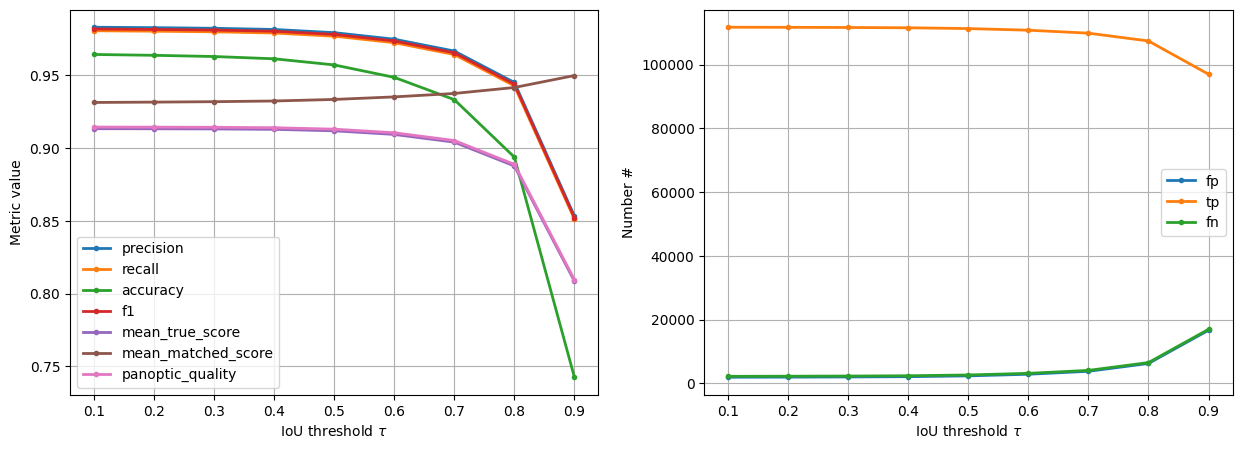

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [50]:
i=80
print(cls_val[i])
print(res_val_pred[i]['class_id'])

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 1, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 0, 140